In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [48]:
test_df=pd.read_csv("../input/covid-19-nlp-text-classification/Corona_NLP_test.csv", encoding="latin-1")
train_df=pd.read_csv("../input/covid-19-nlp-text-classification/Corona_NLP_train.csv", encoding="latin-1")

In [49]:
train_df.shape

(41157, 6)

In [50]:
test_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [51]:
mapping={'Neutral':0, 'Positive':1, 'Extremely Positive':1, 'Negative':2,'Extremely Negative':2}

test_df.Sentiment=test_df.Sentiment.replace(mapping)
train_df.Sentiment=train_df.Sentiment.replace(mapping)

In [52]:
train_df.Sentiment.value_counts()

## thus sampling 7713

1    18046
2    15398
0     7713
Name: Sentiment, dtype: int64

In [53]:
sentiment_samples=[]
for sentiment in train_df['Sentiment'].unique():
        slice_ = train_df.query("Sentiment == @sentiment")
        sentiment_samples.append(slice_.sample(7713, random_state=1))
train_df = pd.concat(sentiment_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [54]:
train_df.Sentiment.value_counts()

### balanced

2    7713
1    7713
0    7713
Name: Sentiment, dtype: int64

In [55]:
## columns needed is orginaltweet
train_data=train_df.OriginalTweet.copy()
train_label=train_df.Sentiment.copy()

test_data=train_df.OriginalTweet.copy()
test_label=train_df.Sentiment.copy()

In [56]:
train_data, train_label

(0        Online shopping during pandemic sounds great, ...
 1        To all the folks hording TP at my local superm...
 2         Remember if anyone in your household shows sy...
 3        @IFPRI bringing some good news! \r\r\n"There i...
 4        Complaints related to the COVID-19 pandemic al...
                                ...                        
 23134    Vernon Black Eyes Oglala and Sara Anderson Oma...
 23135    Fun way to spot #coronavirus scams  Use the #F...
 23136    A major supermarket chain is taking steps to r...
 23137    I went to the supermarket after not having bee...
 23138    Egg and chicken farmers say they're producing ...
 Name: OriginalTweet, Length: 23139, dtype: object,
 0        1
 1        0
 2        2
 3        1
 4        2
         ..
 23134    1
 23135    2
 23136    0
 23137    1
 23138    0
 Name: Sentiment, Length: 23139, dtype: int64)

In [57]:
from nltk.corpus import stopwords
import re

In [58]:
stop_words = stopwords.words('english')

def process_tweet(tweet):
    
    # remove urls
    tweet = re.sub(r'http\S+', ' ', tweet)
    
    # remove html tags
    tweet = re.sub(r'<.*?>', ' ', tweet)
    
    # remove digits
    tweet = re.sub(r'\d+', ' ', tweet)
    
    # remove hashtags
    tweet = re.sub(r'#\w+', ' ', tweet)
    
    # remove mentions
    tweet = re.sub(r'@\w+', ' ', tweet)
    
    #removing stop words
    tweet = tweet.split()
    tweet = " ".join([word for word in tweet if not word in stop_words])
    
    return tweet

In [59]:
train_data = train_data.apply(process_tweet)
test_data = test_data.apply(process_tweet)

In [60]:
max_seq_length=np.max(list(map(lambda x: len(x), train_data)))
max_seq_length

280

In [61]:
tokenizer = Tokenizer(num_words=15000)
tokenizer.fit_on_texts(train_data)

vocab_length = len(tokenizer.word_index) + 1  ## special characters


train_data = tokenizer.texts_to_sequences(train_data)
test_data = tokenizer.texts_to_sequences(test_data)

train_data = pad_sequences(train_data, maxlen=max_seq_length, padding='post')
test_data = pad_sequences(test_data, maxlen=max_seq_length, padding='post')

In [62]:
print("Vocab length:", vocab_length)
print("Max sequence length:", max_seq_length)

Vocab length: 26502
Max sequence length: 280


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 280)]             0         
_________________________________________________________________
word_embedding (Embedding)   (None, 280, 16)           424032    
_________________________________________________________________
bidirectional_layer (Bidirec (None, 280, 512)          420864    
_________________________________________________________________
max_pooling (GlobalMaxPoolin (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0   

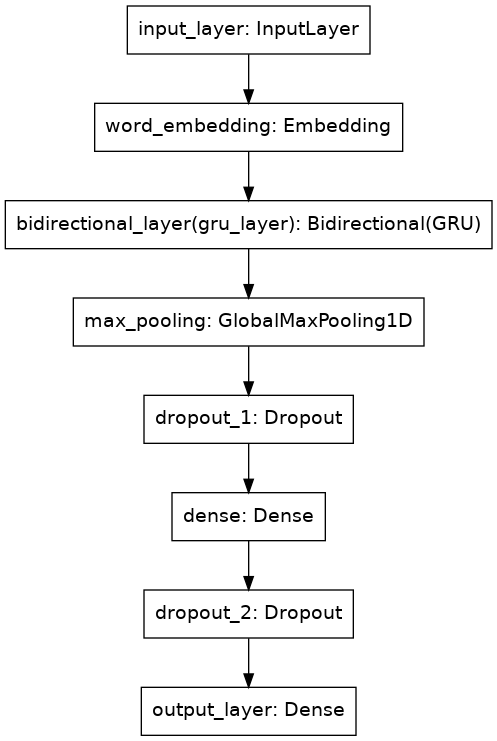

In [71]:
embedding_dim = 16


inputs = tf.keras.Input(shape=(max_seq_length,), name='input_layer')

embedding = tf.keras.layers.Embedding(
    input_dim=vocab_length,
    output_dim=embedding_dim,
    input_length=max_seq_length,
    name='word_embedding'
)(inputs)

gru_layer = tf.keras.layers.Bidirectional(
    tf.keras.layers.GRU(units=256, return_sequences=True, name='gru_layer'),
    name='bidirectional_layer'
)(embedding)

max_pooling = tf.keras.layers.GlobalMaxPool1D(name='max_pooling')(gru_layer) ### 2d flattens 

dropout_1 = tf.keras.layers.Dropout(0.4, name='dropout_1')(max_pooling)

dense = tf.keras.layers.Dense(64, activation='relu', name='dense')(dropout_1)

dropout_2 = tf.keras.layers.Dropout(0.4, name='dropout_2')(dense)

outputs = tf.keras.layers.Dense(3, activation='softmax', name='output_layer')(dropout_2)


model = tf.keras.Model(inputs=inputs, outputs=outputs)

print(model.summary())

tf.keras.utils.plot_model(model)

In [72]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


batch_size = 32
epochs = 2

history = model.fit(
    train_data,
    train_label,
    validation_split=0.12,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1
)

Epoch 1/2
637/637 [==============================] - 33s 46ms/step - loss: 0.9346 - accuracy: 0.5216 - val_loss: 0.4818 - val_accuracy: 0.8297
Epoch 2/2
637/637 [==============================] - 29s 45ms/step - loss: 0.4431 - accuracy: 0.8586 - val_loss: 0.4155 - val_accuracy: 0.8531


In [74]:
import plotly.express as px
fig = px.line(
    history.history,
    y=['loss', 'val_loss'],
    labels={'index': "epoch", 'value': "loss"}
)

fig.show()

In [76]:
loss , acc= model.evaluate(test_data, test_label)
print("Accuracy:", acc)
print("Loss:", loss)

724/724 [==============================] - 12s 16ms/step - loss: 0.2708 - accuracy: 0.9107
Accuracy: 0.9107134938240051
Loss: 0.2708098292350769


In [79]:
y_pred=np.argmax(model.predict(test_data), axis=1)
y_pred

array([1, 0, 0, ..., 0, 1, 0])

In [80]:
clr=classification_report(test_label, y_pred)
print(clr)
cm=confusion_matrix(test_label, y_pred)
print(cm)

              precision    recall  f1-score   support

           0       0.96      0.88      0.92      7713
           1       0.90      0.92      0.91      7713
           2       0.88      0.93      0.90      7713

    accuracy                           0.91     23139
   macro avg       0.91      0.91      0.91     23139
weighted avg       0.91      0.91      0.91     23139

[[6786  445  482]
 [ 111 7114  488]
 [ 152  388 7173]]


# Test Accuracy 91%